<a href="https://colab.research.google.com/github/shushkova/ML_project/blob/main/CAInpainting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [317]:
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

ERROR: Could not find a version that satisfies the requirement PIL (from versions: none)
ERROR: No matching distribution found for PIL


In [318]:
!nvidia-smi

Tue Mar 23 17:45:56 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   64C    P0    29W /  70W |   5106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [319]:
import torch
import numpy as np
import matplotlib.pyplot as plt

In [394]:
def imshow(img, ax=None):
    img = np.squeeze(img)

    if img.ndim == 2:  # black-and-white
        if ax is None:
            return plt.imshow(img, vmin=0, vmax=1, cmap='gray_r')
        else:
            return ax.imshow(img, vmin=0, vmax=1, cmap='gray_r')
    elif img.ndim == 3:
        img = np.transpose(img, (1, 2, 0))
        img = (img + 1) / 2
        if ax is None:
            return plt.imshow(img, vmin=0, vmax=1)
        else:
            return ax.imshow(img, vmin=0, vmax=1)
    else:
        raise Exception(f'img has shape {img.shape}')

# Download MNIST

In [ ]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train / 255
x_test = x_test / 255

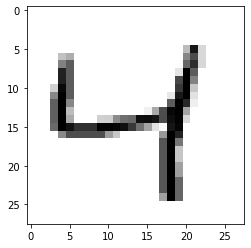

In [ ]:
plt.imshow(x_train[2], cmap='gray_r')
plt.show()

In [ ]:
x_train[2].ndim

2

In [ ]:
def create_rect_mask(img, radius=2):
    assert img.ndim == 2 or img.ndim == 3

    if img.ndim == 3:
        nonz = np.nonzero(img)
        y, x = nonz[:, 1], nonz[:, 2]
    else:
        y, x = np.nonzero(img)
    i = np.random.randint(len(x))
    x = x[i]
    y = y[i]
    mask = np.ones(img.shape[-2:], dtype=np.bool)
    left = max(0, x - radius)
    right = min(img.shape[-1], x + radius + 1)

    top = max(0, y - radius)
    bottom = min(img.shape[-2], y + radius + 1)

    mask[top:bottom, left:right] = 0

    return mask

In [ ]:
from torch.utils.data import Dataset

class MNISTDataset(Dataset):
    def __init__(self, data, mask_creator):
        self.data = data
        self.mask_creator = mask_creator
            
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self,idx):
        img = self.data[idx]
        mask = self.mask_creator(img)

        img = torch.Tensor(img[np.newaxis])
        mask = torch.tensor(mask[np.newaxis], dtype=torch.bool)

        return img, mask

In [ ]:
torch.manual_seed(0)

mnist_train_data = MNISTDataset(x_train, create_rect_mask)
mnist_test_data = MNISTDataset(x_test, create_rect_mask)

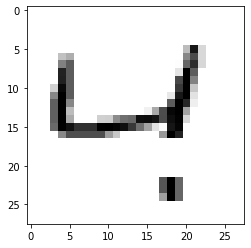

In [ ]:
img, mask = mnist_train_data[2]
imshow(mask * img)

# Download CelebA

In [321]:
!rm -rf data_faces
!mkdir data_faces

In [322]:
!wget https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip 

--2021-03-23 17:46:09--  https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip
Resolving s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)... 52.219.120.248
Connecting to s3-us-west-1.amazonaws.com (s3-us-west-1.amazonaws.com)|52.219.120.248|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1443490838 (1.3G) [application/zip]
Saving to: ‘celeba.zip.1’

celeba.zip.1         50%[=========>          ] 691.06M  41.9MB/s    eta 17s    ^C


In [326]:
import zipfile

with zipfile.ZipFile("celeba.zip","r") as zip_ref:
  zip_ref.extractall("data_faces/")

In [327]:
import os
root = 'data_faces/img_align_celeba'
img_list = os.listdir(root)
print(len(img_list))

202599


In [328]:
import PIL.Image as Image
from torchvision import transforms
import torchvision
from torch.utils.data import DataLoader
import math

""" data """
crop_size = 108
re_size = 48
offset_height = (218 - crop_size) // 2
offset_width = (178 - crop_size) // 2
crop = lambda x: x[:, offset_height:offset_height + crop_size, offset_width:offset_width + crop_size]

transform = transforms.Compose(
    [
     transforms.ToTensor(),
     transforms.Lambda(crop),
     transforms.ToPILImage(),
     transforms.Resize(size=(re_size, re_size), interpolation=transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize(mean=[0.5] * 3, std=[0.5] * 3)
    ]
)

celeba_data = torchvision.datasets.ImageFolder('./data_faces', transform=transform)

In [329]:
from torch.utils.data import Dataset, random_split
import os

class CelebaDataset(Dataset):
    def __init__(self, root_dir, mask_creator, transform=transforms.ToTensor()):
        self.root_dir = root_dir
        self.size = len(os.listdir(self.root_dir))
        self.transform = transform
        self.mask_creator = mask_creator

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        image_path = self.root_dir + f'/{index+1:0>6}.jpg'
        img = Image.open(image_path)
        img = self.transform(img)
        mask = self.mask_creator(img)

        mask = torch.tensor(mask[np.newaxis], dtype=torch.bool)

        return img, mask

In [330]:
import numpy as np

def brush_mask(data_image):
      _, image_height, image_width = data_image.shape

      min_num_vertex = 4
      # max_num_vertex = 12
      max_num_vertex = 12
      mean_angle = 2 * math.pi / 5
      angle_range = 2 * math.pi / 15
      min_width = 2
      # max_width = 40
      max_width = 4
      H, W = image_height, image_width
      average_radius = math.sqrt(H*H+W*W) / 8
      #mask = np.ones(img.shape[-2:], dtype=np.bool)
      mask = Image.new('L', (W, H), 0)

      for _ in range(np.random.randint(1, 4)):
          num_vertex = np.random.randint(min_num_vertex, max_num_vertex)
          angle_min = mean_angle - np.random.uniform(0, angle_range)
          angle_max = mean_angle + np.random.uniform(0, angle_range)
          angles = []
          vertex = []
          for i in range(num_vertex):
              if i % 2 == 0:
                  angles.append(2*math.pi - np.random.uniform(angle_min, angle_max))
              else:
                  angles.append(np.random.uniform(angle_min, angle_max))

          h, w = mask.size
          vertex.append((int(np.random.randint(0, w)), int(np.random.randint(0, h))))
          for i in range(num_vertex):
              r = np.clip(
                  np.random.normal(loc=average_radius, scale=average_radius//2),
                  0, 2*average_radius)
              new_x = np.clip(vertex[-1][0] + r * math.cos(angles[i]), 0, w)
              new_y = np.clip(vertex[-1][1] + r * math.sin(angles[i]), 0, h)
              vertex.append((int(new_x), int(new_y)))

          draw = ImageDraw.Draw(mask)
          width = int(np.random.uniform(min_width, max_width))
          draw.line(vertex, fill=255, width=width)
          for v in vertex:
              draw.ellipse((v[0] - width//2,
                            v[1] - width//2,
                            v[0] + width//2,
                            v[1] + width//2),
                            fill=255)

      if np.random.normal() > 0:
          mask.transpose(Image.FLIP_LEFT_RIGHT)
      if np.random.normal() > 0:
          mask.transpose(Image.FLIP_TOP_BOTTOM)

      # mask = transforms.ToTensor()(mask)
      mask = np.array(mask)
      # mask = mask.reshape((1, 1, H, W))
      mask = mask.reshape((H, W))
      brush_mask = mask

      # mask = np.ones_like(data_image)
      # mask = np.ones(data_image.shape[-2:], dtype=np.bool)

      #for i in range(data_image.shape[2]):
      #    mask[:,:,i] = brush_mask

      mask = np.logical_not(brush_mask)

      return mask

In [331]:
celeba_data = CelebaDataset('data_faces/img_align_celeba', brush_mask, transform=transform)

train_size = round(len(celeba_data)*.5)
test_size = round(len(celeba_data)*.05)
rest = len(celeba_data) - train_size - test_size

celeba_train_data, celeba_test_data, _ = random_split(celeba_data, [train_size, test_size, rest])

In [332]:
print(train_size)

101300


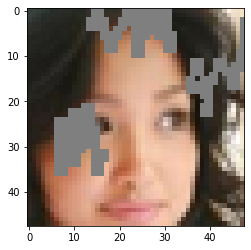

In [333]:
from PIL import Image, ImageDraw

img, mask = celeba_train_data[4]
imshow(img * mask)

# Define vanilla model

In [ ]:
from torch import nn

class CAInpaintig(torch.nn.Module):
    def __init__(self, img_channels, state_size, hidden_size):
        super(CAInpaintig, self).__init__()
        
        self.state_size = state_size

        # img_channels for img + 1 for mask
        self.conv1 = nn.Conv2d(in_channels=img_channels + 1 + state_size,
                               out_channels=hidden_size,
                               kernel_size=(3, 3),
                               padding=1)
        self.activation1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=hidden_size,
                               out_channels=hidden_size,
                               kernel_size=(1, 1))
        self.activation2 = nn.ReLU()

        self.conv_state = nn.Conv2d(in_channels=hidden_size,
                                    out_channels=state_size,
                                    kernel_size=(1, 1))
        
        self.conv_img = nn.Conv2d(in_channels=hidden_size,
                                  out_channels=img_channels,
                                  kernel_size=(1, 1))
        
    def forward(self, img, mask, state):
        x = torch.cat((img, mask, state), dim=1)

        x = self.activation1(self.conv1(x))
        x = self.activation2(self.conv2(x))

        img_pred = self.conv_img(x)
        state_update = self.conv_state(x)

        return img_pred, state_update

    def gen_initial_state(self, batch_shape):
        return torch.randn((batch_shape[0], self.state_size, batch_shape[2], batch_shape[3]))

In [ ]:
def update_img_and_state(img, mask, state, img_pred, state_update, device='cuda'):
    # Img has only one channel
    mask_update = torch.ones_like(mask) / 2
    mask_update = torch.bernoulli(mask_update).bool()
    mask_update = mask_update.to(device)

    # Update state according to bernoulli
    state += state_update * mask_update

    # Update unknown part of an image according to bernoulli
    # There are 3 types of pixels:
    # 1. Known pixels (indicated by mask)
    # 2. Unknown pixels to update (indicated by ~mask and mask_update)
    # 3. Unknown pixels without update (indicated by ~mask and ~mask_update)
    # mask_update = torch.squeeze(mask_update)
    # img_pred = torch.squeeze(img_pred)
    img = mask * img + (~mask) * (mask_update * img_pred + (~mask_update) * img)

    return img, state

In [ ]:
from tqdm.notebook import tqdm

def test(epoch, net, criterion,
         val_loader,
         without_loss_iters=1, with_loss_iters=1, repeat_iters=1,
         device='cuda'):
    net.to(device)
    net.eval()
    with torch.no_grad():
        losses_val = []
        pbar = tqdm(val_loader, desc=f'Valid (epoch = {epoch})')
        for img, mask in pbar:
            state = net.gen_initial_state(img.shape)

            img, mask, state = img.to(device), mask.to(device), state.to(device)

            original_img = img.detach().clone()

            loss = 0
            for _ in range(repeat_iters):
                for _ in range(without_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                for _ in range(with_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                    loss += criterion(img_pred, original_img)

            losses_val.append(loss.item())
            pbar.set_postfix({'loss': sum(losses_val) / len(losses_val)})
        return losses_val


def train(epochs, net, criterion, optimizer,
          train_loader, val_loader,
          without_loss_iters=1, with_loss_iters=1, repeat_iters=1,
          scheduler=None, verbose=True, device='cuda'):
    net.to(device)
    freq = max(epochs//15,1)

    for epoch in range(1, epochs+1):
        net.train()

        losses_train = []
        pbar = tqdm(train_loader, desc=f'Train (epoch = {epoch})')
        for img, mask in pbar:
            state = net.gen_initial_state(img.shape)

            img, mask, state = img.to(device), mask.to(device), state.to(device)

            original_img = img.detach().clone()

            loss = 0
            for _ in range(repeat_iters):
                for _ in range(without_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                for _ in range(with_loss_iters):
                    img_pred, state_update = net(img * mask, mask, state)
                    img, state = update_img_and_state(img, mask, state,
                                                    img_pred, state_update,
                                                    device=device)

                    loss += criterion(img_pred, original_img)

            optimizer.zero_grad()

            loss.backward()
            optimizer.step()

            losses_train.append(loss.item())
            pbar.set_postfix({'loss': sum(losses_train) / len(losses_train)})

        if scheduler is not None:
            scheduler.step()


        if verbose and epoch % freq == 0:
            net.eval()
            losses_val = []
            pbar = tqdm(val_loader, desc=f'Valid (epoch = {epoch})')
            for img, mask in pbar:
                state = net.gen_initial_state(img.shape)

                img, mask, state = img.to(device), mask.to(device), state.to(device)

                original_img = img.detach().clone()
                
                loss = 0
                for _ in range(repeat_iters):
                    for _ in range(without_loss_iters):
                        img_pred, state_update = net(img * mask, mask, state)
                        img, state = update_img_and_state(img, mask, state,
                                                        img_pred, state_update,
                                                        device=device)

                    for _ in range(with_loss_iters):
                        img_pred, state_update = net(img * mask, mask, state)
                        img, state = update_img_and_state(img, mask, state,
                                                        img_pred, state_update,
                                                        device=device)

                        loss += criterion(img_pred, original_img)

                losses_val.append(loss.item())
                pbar.set_postfix({'loss': sum(losses_val) / len(losses_val)})

# Vanilla: Params + Training

In [ ]:
STATE_SIZE = 32
HIDDEN_SIZE = 64
BATCH_SIZE = 64

In [ ]:
from torch.utils.data import DataLoader

# IMG_CHANNELS = 1
# train_loader = DataLoader(mnist_train_data, batch_size=BATCH_SIZE, shuffle=True)
# val_loader = DataLoader(mnist_test_data, batch_size=BATCH_SIZE, shuffle=True)

IMG_CHANNELS = 3
train_loader = DataLoader(celeba_train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(celeba_test_data, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
net = CAInpaintig(img_channels=IMG_CHANNELS, state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
# scheduler = None

In [ ]:
train(4, net, criterion, optimizer,
      train_loader, val_loader,
      without_loss_iters=15, with_loss_iters=5,
      scheduler=scheduler, verbose=True, device='cuda')

In [ ]:
torch.save(net.state_dict(), 'net_3c.pt')

In [ ]:
net.load_state_dict(torch.load('net_3c.pt'))
net.eval()

CAInpaintig(
  (conv1): Conv2d(34, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (activation1): ReLU()
  (conv2): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (activation2): ReLU()
  (conv_state): Conv2d(64, 30, kernel_size=(1, 1), stride=(1, 1))
  (conv_img): Conv2d(64, 3, kernel_size=(1, 1), stride=(1, 1))
)

In [ ]:
_ = test(1, net, criterion,
         val_loader,
         without_loss_iters=15, with_loss_iters=5,
         device='cuda')

# Visualization of vanilla model

In [ ]:
# Gets batch of images
def predict_all(net, img, mask, iters=1, device='cuda'):
    state = net.gen_initial_state(img.shape)

    img, mask, state = img.to(device), mask.to(device), state.to(device)

    imgs_pred = torch.empty((iters,) + img.shape)
    for i in range(iters):
        img_pred, state_update = net(img * mask, mask, state)

        img, state = update_img_and_state(img, mask, state, img_pred, state_update, device=device)

        imgs_pred[i] = img_pred.cpu().detach()

    return imgs_pred

# Gets batch of images
def predict(net, img, mask, iters=1, device='cuda'):
    return predict_all(net, img, mask, iters, device)[-1]

In [ ]:
# Gets one image
def show_prediction(net, img, mask, img_pred, iters=1, n_rows=1, idx=0, device='cuda'):
    n_cols = 5
    if n_rows == 1:
        plt.figure(figsize=(16, 3))

    plt.subplot(n_rows, n_cols, idx * n_cols + 1)
    plt.title('Original image')
    imshow(img)

    plt.subplot(n_rows, n_cols, idx * n_cols + 2)
    plt.title('Mask')
    imshow(mask.type(torch.float32))

    plt.subplot(n_rows, n_cols, idx * n_cols + 3)
    plt.title('Masked image')
    imshow(img * mask)

    plt.subplot(n_rows, n_cols, idx * n_cols + 4)
    plt.title('Reconstructed image')
    imshow(img_pred)

    plt.subplot(n_rows, n_cols, idx * n_cols + 5)
    plt.title('Difference image')
    imshow(np.abs(img_pred - img))

# Gets batch of images
def show_predictions(net, imgs, masks, iters=1, device='cuda'):
    n_rows = len(imgs)
    
    imgs_pred = predict(net, imgs, masks, iters=iters, device=device)

    plt.figure(figsize=(16, 3.5 * n_rows))
    for idx in range(n_rows):
        show_prediction(net, imgs[idx], masks[idx], imgs_pred[idx],
                        iters=iters, n_rows=n_rows, idx=idx,
                        device=device)
    

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-0.9765) tensor(1.)
tensor(0.) tensor(1.)
tensor(-0.9765) tensor(1.)
tensor(-1.0847) tensor(1.0467)
tensor(1.1325e-06) tensor(0.4488)
tensor(-1.) tensor(0.8510)
tensor(0.) tensor(1.)
tensor(-1.) tensor(0.8275)
tensor(-1.0172) tensor(0.8311)
tensor(3.6955e-06) tensor(0.3786)
tensor(-1.) tensor(1.)
tensor(0.) tensor(1.)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(-1.) tensor(1.)
tensor(-1.0332) tensor(1.0471)
tensor(8.9407e-07) tensor(0.7713)
tensor(-0.9922) tensor(1.)
tensor(0.) tensor(1.)
tensor(-0.9137) tensor(1.)
tensor(-0.9146) tensor(1.0316)
tensor(4.7684e-07) tensor(1.2021)
tensor(-1.) tensor(0.9137)
tensor(0.) tensor(1.)
tensor(-1.) tensor(0.8431)
tensor(-1.1376) tensor(0.8784)
tensor(5.3644e-07) tensor(0.8628)


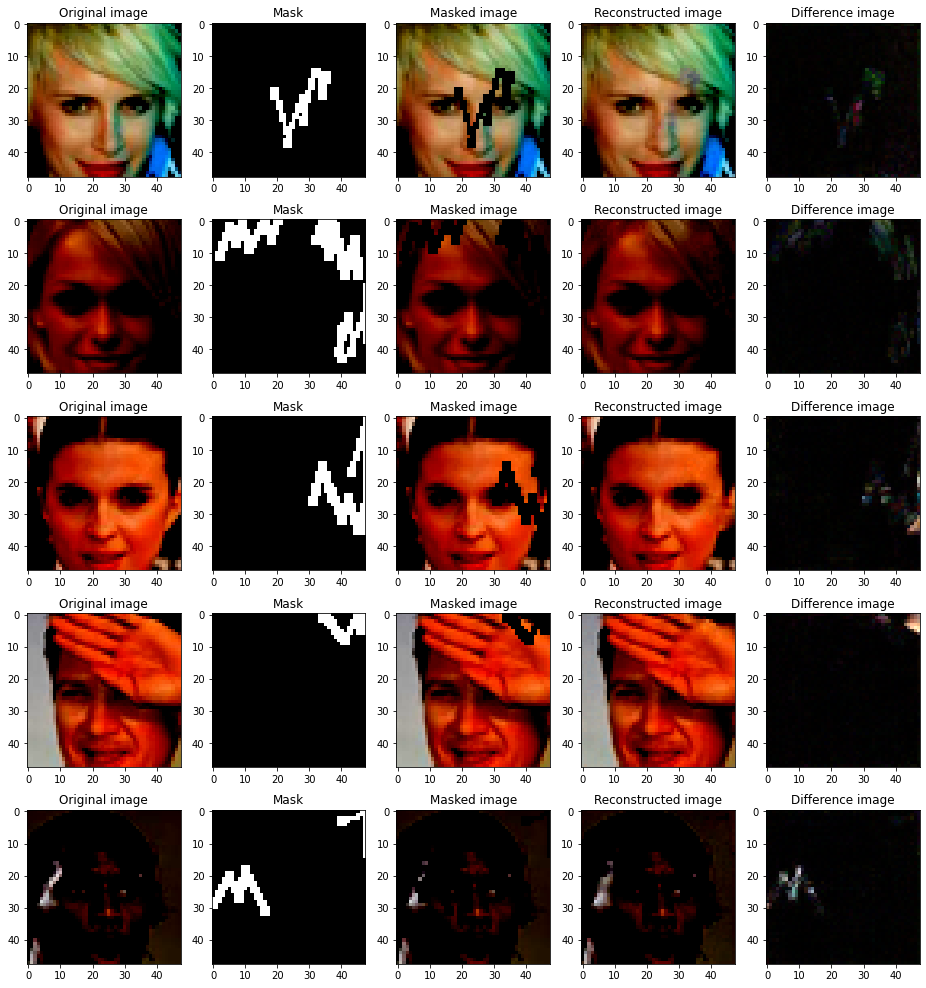

In [ ]:
imgs, masks = next(iter(val_loader))

show_predictions(net, imgs[:5], masks[:5], iters=18)

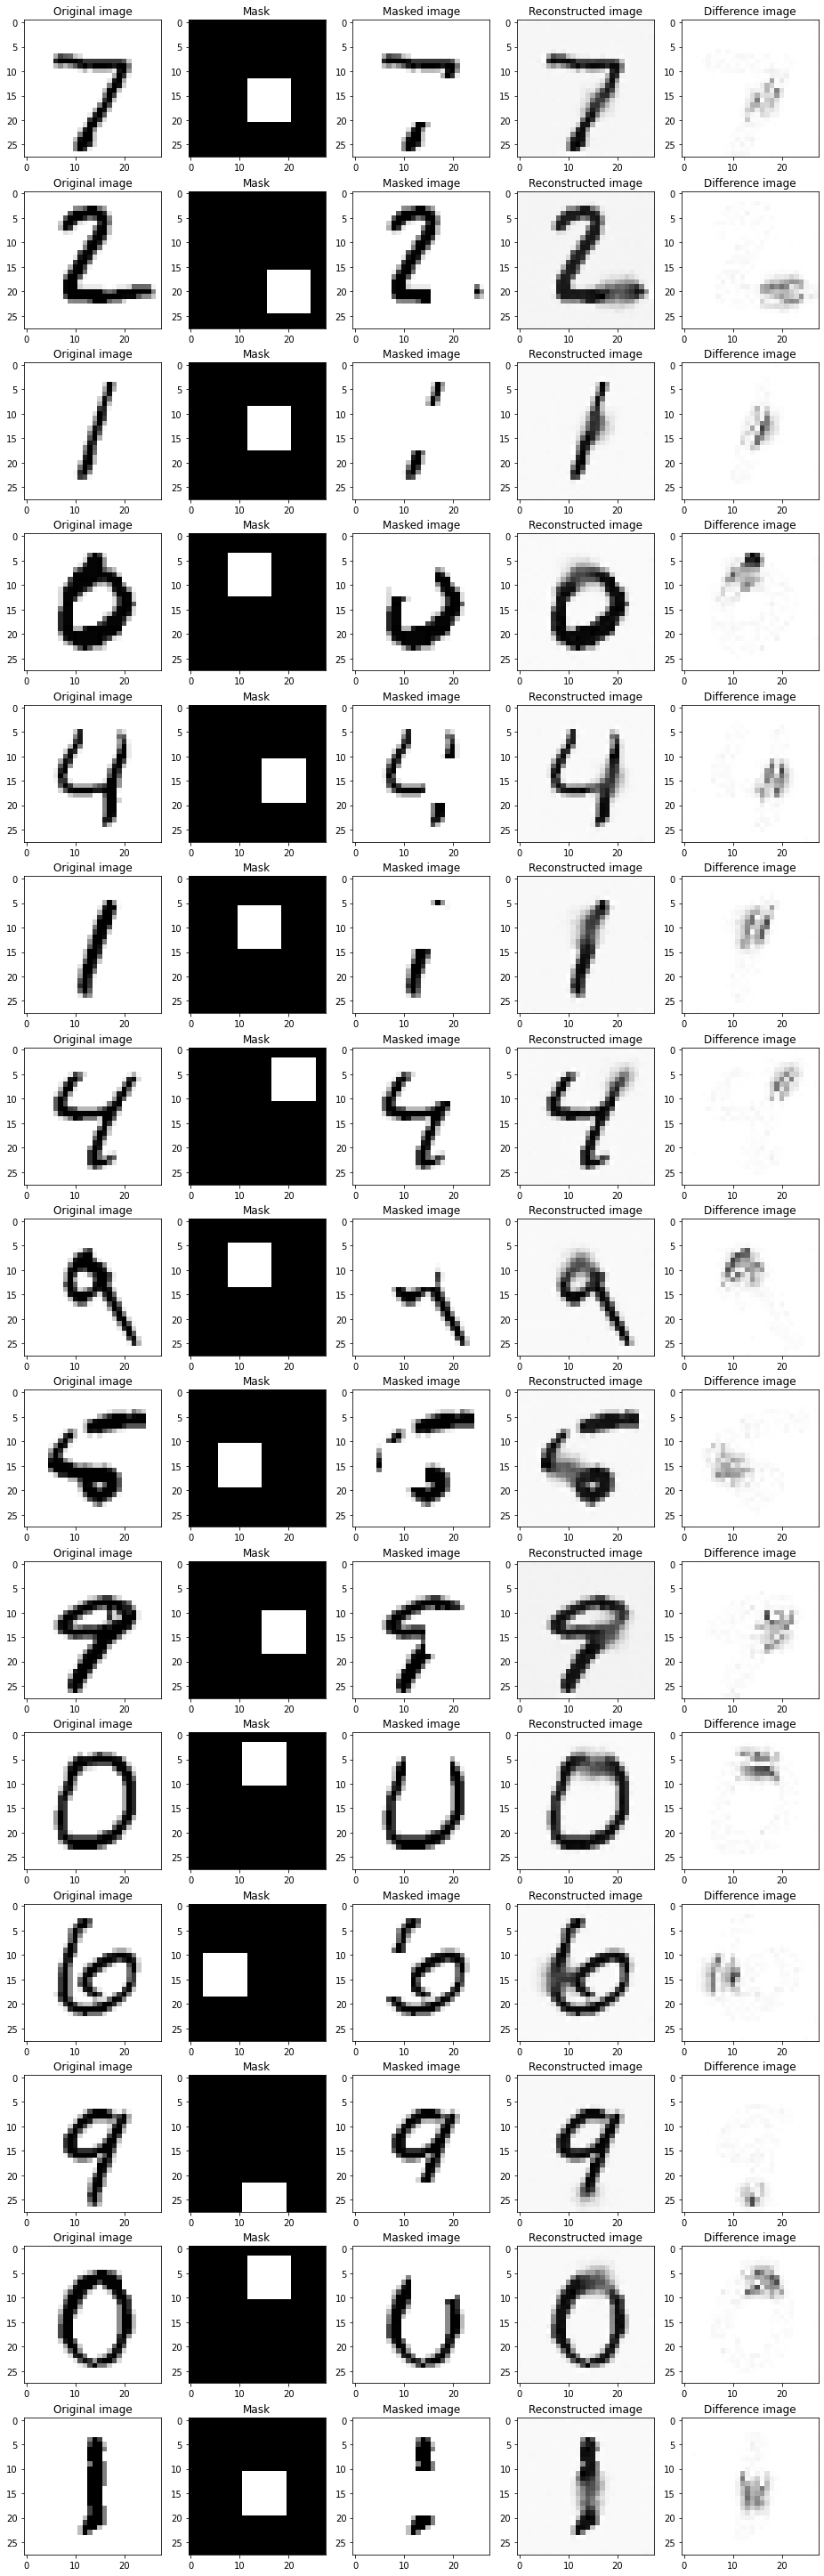

In [ ]:
show_predictions(net, x_test[:15], iters=14)

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import matplotlib.animation as animation


def animate_evolution(filename, net, img, mask, iters=None, fps=None, vlines=None):
    if len(filename) < 4 or filename[-4:] != '.mp4':
        filename += '.mp4'
    assert iters is not None
    assert fps is not None

    mse = nn.MSELoss()

    snapshots = predict_all(net, img, mask, iters=iters)
    frames = len(snapshots)

    # First set up the figure, the axis, and the plot element we want to animate
    # fig = plt.figure(figsize=(1, 1))

    fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(16, 16))
    gs = axs[1, 0].get_gridspec()
    for ax in axs[1]:
        ax.remove()

    axbig = fig.add_subplot(gs[1, :])

    # Plot MSE Loss
    y = []
    for i in range(len(snapshots)):
        y.append(mse(snapshots[i], img).item())

    axbig.set_title('MSE Loss')
    axbig.set_xlabel('Step')
    axbig.plot(np.arange(len(y)), y, label='MSE')
    if vlines is not None:
        for i in range(len(vlines)):
            axbig.axvline(vlines[i], ls='--', color='g')
    line = axbig.axvline(0, ls='-', color='r', label='Current step')
    axbig.legend()


    # Original image
    axs[0, 0].set_title('Original image')
    imshow(img * mask, axs[0, 0])

    # Predicted image
    axs[0, 1].set_title('Reconstructed image')
    a = snapshots[0]
    im = imshow(snapshots[0], axs[0, 1])


    pbar = tqdm(total=frames + 1)
    def animate_func(i):
        pbar.update(1)
        curr_img = snapshots[i]
        curr_img = np.squeeze(curr_img)
        if curr_img.ndim == 3:
            curr_img = np.transpose(curr_img, (1, 2, 0))
            curr_img += 1
            curr_img /= 2
        im.set_array(curr_img)

        line.set_xdata([i])
        return [im, line]

    anim = animation.FuncAnimation(
                                fig, 
                                animate_func, 
                                frames = frames,
                                interval = 1000 / fps, # in ms
                                )

    anim.save(filename, fps=fps, extra_args=['-vcodec', 'libx264'])
    pbar.close()

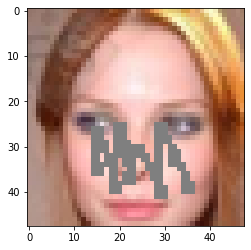

In [ ]:
img, mask = next(iter(val_loader))
img = img[0:1]
mask = mask[0:1]
imshow(img * mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

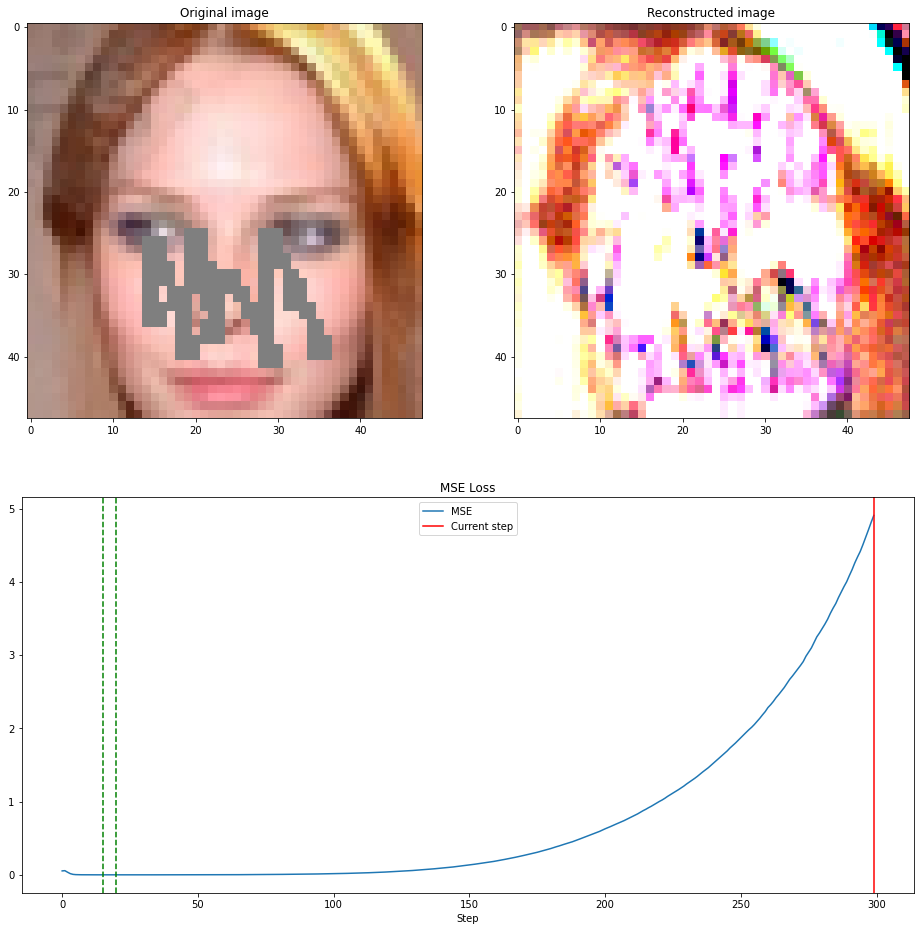

In [ ]:
animate_evolution('test', net, img, mask, iters=300, fps=20, vlines=[15, 20])

# Define GANs model

In [445]:
from torch import nn

class CAInpaintigGenerator(torch.nn.Module):
    def __init__(self, img_channels,
                 state_size, hidden_size,
                 skip_gen_iters, gen_iters, repeats):
        # The model iterates 'skip_gen_iters' times without generation of new images
        # Then the model iterates 'gen_iters' times generating an image on each step
        # And the model repeats it 'repeats' times

        super(CAInpaintigGenerator, self).__init__()
        
        self.state_size = state_size

        assert gen_iters >= 1
        assert repeats >= 1
        self.skip_gen_iters = skip_gen_iters
        self.gen_iters = gen_iters
        self.repeats = repeats

        # img_channels for img + 1 for mask
        self.conv1 = nn.Conv2d(in_channels=img_channels + 1 + state_size,
                               out_channels=hidden_size,
                               kernel_size=(3, 3),
                               padding=1)
        self.activation1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=hidden_size,
                               out_channels=hidden_size,
                               kernel_size=(1, 1))
        self.activation2 = nn.ReLU()

        self.conv_state = nn.Conv2d(in_channels=hidden_size,
                                    out_channels=state_size,
                                    kernel_size=(1, 1))
        
        self.conv_img = nn.Conv2d(in_channels=hidden_size,
                                  out_channels=img_channels,
                                  kernel_size=(1, 1))

    def _step(self, img, mask, state):
        x = torch.cat((img, mask, state), dim=1)

        x = self.activation1(self.conv1(x))
        x = self.activation2(self.conv2(x))

        img_pred = self.conv_img(x)
        state_update = self.conv_state(x)

        return img_pred, state_update

    def _gen_initial_state(self, batch_shape):
        return torch.randn((batch_shape[0], self.state_size, batch_shape[2], batch_shape[3]))

    @staticmethod
    def _update_img_and_state(img, mask, state, img_pred, state_update):
        # Img has only one channel
        mask_update = torch.ones_like(mask) / 2
        mask_update = torch.bernoulli(mask_update).bool()
        mask_update = mask_update.to(img.device)

        # Update state according to bernoulli
        state += state_update * mask_update

        # Update unknown part of an image according to bernoulli
        # There are 3 types of pixels:
        # 1. Known pixels (indicated by mask)
        # 2. Unknown pixels to update (indicated by ~mask and mask_update)
        # 3. Unknown pixels without update (indicated by ~mask and ~mask_update)
        # mask_update = torch.squeeze(mask_update)
        # img_pred = torch.squeeze(img_pred)
        img = mask * img + (~mask) * (mask_update * img_pred + (~mask_update) * img)

        return img, state

    def forward(self, img, mask, iterates_for_test=None, output_raw_predicted=False):
        # If 'iterates_for_test' is not None, the model is considered to be in testing stage
        # In this case the model generates images on selected iterations
        # 
        # The method always retuns the list of generated images on different iterations.
        # Even if the was only one iteration for generation

        state = self._gen_initial_state(img.shape)
        state = state.to(img.device)

        all_generated_images = []
        if iterates_for_test is None:
            for _ in range(self.repeats):
                for _ in range(self.skip_gen_iters):
                    img_pred, state_update = self._step(img, mask, state)
                    img, state = self._update_img_and_state(img, mask, state,
                                                            img_pred, state_update)
                for _ in range(self.gen_iters):
                    img_pred, state_update = self._step(img, mask, state)
                    img, state = self._update_img_and_state(img, mask, state,
                                                            img_pred, state_update)
                    all_generated_images.append(img_pred if output_raw_predicted else img)
        else:
            if isinstance(iterates_for_test, int):
                iterates_for_test = [iterates_for_test]
            iterates_for_test.sort()
            total_iterations = iterates_for_test[-1]
            for i in range(total_iterations + 1):
                img_pred, state_update = self._step(img, mask, state)
                img, state = self._update_img_and_state(img, mask, state,
                                                        img_pred, state_update)
                if i == iterates_for_test[0]:
                    all_generated_images.append(img_pred if output_raw_predicted else img)
                    iterates_for_test = iterates_for_test[1:]
        return all_generated_images

In [523]:
class Discriminator(nn.Module):
    def __init__(self, img_channels, img_size):
        super(Discriminator, self).__init__()

        kernel_size = 5
        stride = 2
        padding = 1

        def discriminator_block(in_filters, out_filters):
            # block = [nn.Conv2d(in_filters, out_filters, 3, 2, 1), nn.LeakyReLU(0.2, inplace=True), nn.Dropout2d(0.25)]
            block = [
                     nn.utils.spectral_norm(nn.Conv2d(in_filters, out_filters, kernel_size, stride, padding)),
                     nn.LeakyReLU(0.2, inplace=True)
                    ]
            return block

        self.model = nn.Sequential(
            *discriminator_block(img_channels, 16),
            *discriminator_block(16, 32),
            *discriminator_block(32, 64),
            *discriminator_block(64, 128),
        )

        self.flatten = nn.Flatten()

        # The height and width of downsampled image
        ds_size = img_size
        for i in range(4):
            ds_size = (ds_size + 2 * padding - (kernel_size - 1) - 1) // stride + 1
        self.adv_layer = nn.Sequential(nn.Linear(128 * ds_size ** 2, 1), nn.Sigmoid())

    def forward(self, img):
        out = self.model(img)
        # out = out.view(out.shape[0], -1)
        out = self.flatten(out)
        validity = self.adv_layer(out)

        return validity

In [598]:
from tqdm.notebook import tqdm

def test_gan(epoch, generator, discriminator, criterion,
         val_loader,
         device='cuda'):
    raise Exception('Not implemented')
    generator.to(device)
    generator.eval()   
    discriminator.to(device)
    discriminator.eval()
    with torch.no_grad():
        losses_val = []
        pbar = tqdm(val_loader, desc=f'Valid (epoch = {epoch})')
        for img, mask in pbar:
            img, mask = img.to(device), mask.to(device)

            original_img = img.detach().clone()

            all_generated_imgs = net(img * mask, mask)
            loss = 0
            losses_val.append(loss.item())
            pbar.set_postfix({'loss': sum(losses_val) / len(losses_val)})
        return losses_val


def train_gan(epochs, generator, discriminator,
          criterion, optimizer_G, optimizer_D,
          train_loader, val_loader,
          scheduler=None, verbose=True, device='cuda'):
    generator.to(device)
    discriminator.to(device)
    freq = max(epochs//15,1)

    mse = nn.MSELoss()

    for epoch in range(1, epochs+1):
        generator.train()
        discriminator.train()

        g_losses_train = []
        d_losses_train = []
        pbar = tqdm(train_loader, desc=f'Train (epoch = {epoch})')
        mse_train = []
        for img, mask in pbar:
            # Adversarial ground truths
            valid = torch.autograd.Variable(torch.Tensor(img.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
            fake = torch.autograd.Variable(torch.Tensor(img.shape[0], 1).fill_(0.0), requires_grad=False).to(device)

            img, mask = img.to(device), mask.to(device)

            original_img = img.detach().clone()

            # -----------------
            #  Train Generator
            # -----------------

            optimizer_G.zero_grad()

            gen_imgs = generator(img, mask, output_raw_predicted=False)
            # g_loss = criterion(discriminator(gen_imgs), valid)
            g_loss = 0
            curr_mse = 0
            for gen_img in gen_imgs:
                g_loss += criterion(discriminator(gen_img), valid)
                curr_mse += mse(gen_img, original_img)
            g_loss /= len(gen_imgs)
            curr_mse /= len(gen_imgs)
            curr_mse *= 1 - torch.sum(mask) / np.prod(mask.size())

            g_loss.backward()
            optimizer_G.step()

            # ---------------------
            #  Train Discriminator
            # ---------------------

            optimizer_D.zero_grad()

            real_loss = criterion(discriminator(original_img), valid)
            fake_loss = 0
            for gen_img in gen_imgs:
                fake_loss += criterion(discriminator(gen_img.detach()), fake)
            fake_loss /= len(gen_imgs)
            # fake_loss = criterion(discriminator(gen_imgs.detach()), fake)

            d_loss = (real_loss + fake_loss) / 2

            d_loss.backward()
            optimizer_D.step()

            # --------------
            #  Print losses
            # --------------

            g_losses_train.append(g_loss.item())
            d_losses_train.append(d_loss.item())
            mse_train.append(curr_mse.item())
            pbar.set_postfix({
                              # 'G loss': sum(g_losses_train) / len(g_losses_train),
                              # 'D loss': sum(d_losses_train) / len(d_losses_train),
                              # 'MSE': sum(mse_train) / len(mse_train),
                              'G loss (last 50)': sum(g_losses_train[-min(50, len(g_losses_train)):]) / min(50, len(g_losses_train)),
                              'D loss (last 50)': sum(d_losses_train[-min(50, len(d_losses_train)):]) / min(50, len(d_losses_train)),
                              'MSE (last 50)': sum(mse_train[-min(50, len(mse_train)):]) / min(50, len(mse_train)),
                              })

        if scheduler is not None:
            scheduler.step()

        if verbose and epoch % freq == 0:
            test(epoch, generator, discriminator, criterion,
                 val_loader,
                 device=device)

# GANs: Params + Training

In [526]:
STATE_SIZE = 32
HIDDEN_SIZE = 64
BATCH_SIZE = 64

In [527]:
from torch.utils.data import DataLoader

'''
IMG_CHANNELS = 1
IMG_SIZE = mnist_train_data[0][0].shape[-1]
train_loader = DataLoader(mnist_train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(mnist_test_data, batch_size=BATCH_SIZE, shuffle=True)
'''

IMG_CHANNELS = 3
IMG_SIZE = celeba_train_data[0][0].shape[-1]
train_loader = DataLoader(celeba_train_data, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(celeba_test_data, batch_size=BATCH_SIZE, shuffle=True)

In [612]:
# Generator
generator = CAInpaintigGenerator(img_channels=IMG_CHANNELS,
                                 state_size=STATE_SIZE, hidden_size=HIDDEN_SIZE,
                                 skip_gen_iters=5, gen_iters=10, repeats=1)
# Discriminator
discriminator = Discriminator(img_channels=IMG_CHANNELS, img_size=IMG_SIZE)


adversarial_loss = torch.nn.BCELoss()

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-3)
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-3)

# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)
scheduler = None

In [530]:
img, mask = next(iter(train_loader))
# img = img.to('cuda')
# mask = mask.to('cuda')
generated_img = generator(img, mask)
_ = discriminator(generated_img[0])

In [631]:
train_gan(3,
          generator, discriminator,
          adversarial_loss, optimizer_G, optimizer_D,
          train_loader, val_loader,
          scheduler=scheduler, verbose=False, device='cuda'
          )

# Visualization of GAN model

In [628]:
# Gets batch of images
def generate_all(generator, img, mask, iters=None, device='cuda'):
    img, mask = img.to(device), mask.to(device)

    generator.eval()
    with torch.no_grad():
        imgs_generated = generator(img * mask, mask, iters, True)

    for i in range(len(imgs_generated)):
        imgs_generated[i] = imgs_generated[i].cpu().detach()

    return imgs_generated

# Gets batch of images
def generate(generator, img, mask, iters=None, device='cuda'):
    return generate_all(generator, img, mask, iters, device)[-1]

In [623]:
# Gets one image
def show_generated(img, mask, img_generated, n_rows=1, idx=0, device='cuda'):
    n_cols = 5
    if n_rows == 1:
        plt.figure(figsize=(16, 3))

    plt.subplot(n_rows, n_cols, idx * n_cols + 1)
    plt.title('Original image')
    imshow(img)

    plt.subplot(n_rows, n_cols, idx * n_cols + 2)
    plt.title('Mask')
    imshow(mask.type(torch.float32))

    plt.subplot(n_rows, n_cols, idx * n_cols + 3)
    plt.title('Masked image')
    imshow(img * mask)

    plt.subplot(n_rows, n_cols, idx * n_cols + 4)
    plt.title('Reconstructed image')
    imshow(img_generated)

    plt.subplot(n_rows, n_cols, idx * n_cols + 5)
    plt.title('Difference image')
    imshow(np.abs(img_generated - img))

# Gets batch of images
def show_generateds(generator, imgs, masks, iters=None, device='cuda'):
    n_rows = len(imgs)
    
    imgs_pred = generate(generator, imgs, masks, iters=iters, device=device)

    plt.figure(figsize=(16, 3.5 * n_rows))
    for idx in range(n_rows):
        show_generated(imgs[idx], masks[idx], imgs_pred[idx],
                       n_rows=n_rows, idx=idx,
                       device=device)
    

In [624]:
imgs, masks = next(iter(train_loader))


img_generated = generate(generator, imgs, masks)
img_generated.min(), img_generated.max()

(tensor(-1.1920), tensor(1.5770))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


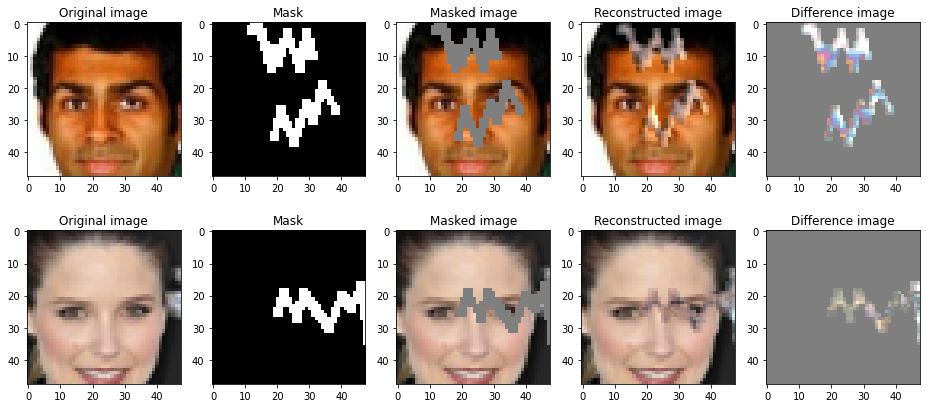

In [627]:
imgs, masks = next(iter(train_loader))
N = 2

# generated = generate(generator, imgs[:N], masks[:N])

show_generateds(generator, imgs[:N], masks[:N], iters=12)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


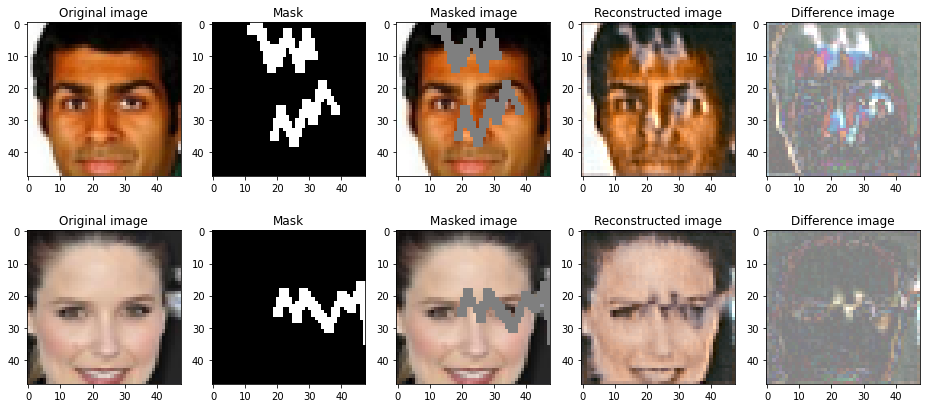

In [629]:
show_generateds(generator, imgs[:N], masks[:N], iters=12)